In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/mooccubex-dataset/course-teacher.txt
/kaggle/input/mooccubex-dataset/course.json
/kaggle/input/mooccubex-dataset/paper.json
/kaggle/input/mooccubex-dataset/reply.json
/kaggle/input/mooccubex-dataset/concept-comment.txt
/kaggle/input/mooccubex-dataset/user-video.json
/kaggle/input/mooccubex-dataset/course-comment.txt
/kaggle/input/mooccubex-dataset/concept-problem.txt
/kaggle/input/mooccubex-dataset/user-reply.txt
/kaggle/input/mooccubex-dataset/school.json
/kaggle/input/mooccubex-dataset/translated_reply.json
/kaggle/input/mooccubex-dataset/video.json
/kaggle/input/mooccubex-dataset/concept-video.txt
/kaggle/input/mooccubex-dataset/other.json
/kaggle/input/mooccubex-dataset/course-school.txt
/kaggle/input/mooccubex-dataset/problem.json
/kaggle/input/mooccubex-dataset/user-comment.txt
/kaggle/input/mooccubex-dataset/user.json
/kaggle/input/mooccubex-dataset/exercise-problem.txt
/kaggle/input/mooccubex-dataset/concept-paper.txt
/kaggle/input/mooccubex-dataset/translated_com

In [2]:
basePath = '/kaggle/input/mooccubex-dataset/'
basePathComment = '/kaggle/input/mooccomments/'

In [3]:
import pyspark 
from pyspark.sql import SparkSession
import warnings
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, col, sum, from_unixtime, hour, dayofweek, count, round, when, isnull
from pyspark.sql.types import IntegerType
import seaborn as sns
import matplotlib.pyplot as plt 
from os import truncate

warnings.filterwarnings("ignore")

In [4]:
spark = SparkSession.builder \
    .appName("MySparkApplication") \
    .master("local[*]") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/08 00:04:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
!ls {basePath}

comment-reply.txt    course-school.txt	      translated_reply.json
concept-comment.txt  course-teacher.txt       user-comment.txt
concept.json	     exercise-problem.txt     user.json
concept-other.txt    other.json		      user-problem.json
concept-paper.txt    paper.json		      user-reply.txt
concept-problem.txt  problem.json	      user-video.json
concept-reply.json   reply.json		      user-xiaomu.json
concept-video.txt    reply-reply.txt	      video_id-ccid.txt
course-comment.txt   school.json	      video.json
course-field.json    teacher.json
course.json	     translated_comment.json


In [6]:
df_user_video = spark.read.json(basePath + '/user-video.json')
df_user_video.show(truncate=True)

+--------------------+-------+
|                 seq|user_id|
+--------------------+-------+
|[{[{190.0, 158843...|  U_112|
|[{[{506.0, 160406...|  U_150|
|[{[{4556.8, 15981...|  U_172|
|[{[{109.0, 159883...|  U_189|
|[{[{64.747, 15821...|  U_197|
|[{[{206.8, 159814...|  U_382|
|[{[{598.978027343...|  U_514|
|[{[{9.388, 160075...|  U_670|
|[{[{99.5, 1580808...|  U_783|
|[{[{454.848426, 1...|  U_796|
|[{[{231.0, 160258...|  U_817|
|[{[{567.2, 160078...|  U_981|
|[{[{595.0, 157961...| U_1071|
|[{[{9.7, 15989332...| U_1073|
|[{[{324.4, 158791...| U_1193|
|[{[{924.9, 158436...| U_1206|
|[{[{36.5, 1580867...| U_1323|
|[{[{391.5, 160091...| U_1361|
|[{[{130.4, 159765...| U_1368|
|[{[{1214.0, 16037...| U_1418|
+--------------------+-------+
only showing top 20 rows



In [7]:
df_user_video.count() 

310360

In [8]:
df_user_video.printSchema()

root
 |-- seq: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- segment: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end_point: double (nullable = true)
 |    |    |    |    |-- local_start_time: long (nullable = true)
 |    |    |    |    |-- speed: double (nullable = true)
 |    |    |    |    |-- start_point: double (nullable = true)
 |    |    |-- video_id: string (nullable = true)
 |-- user_id: string (nullable = true)



In [9]:
from pyspark.sql.functions import explode
# Explode the outer array in 'seq' to get each video sequence as a row
df_exploded = df_user_video.select("user_id", explode("seq").alias("video_sequence"))

# Select the video_id and explode the 'segment' array within each video sequence
df_exploded = df_exploded.select(
    "user_id",
    df_exploded["video_sequence"]["video_id"].alias("video_id"),
    explode(df_exploded["video_sequence"]["segment"]).alias("segment_details")
)

# Select the individul fields from the 'segment_details' struct 
df_flattened = df_exploded.select(
    "user_id", 
    "video_id", 
    df_exploded["segment_details"]["start_point"].alias("start_point"),
    df_exploded["segment_details"]["end_point"].alias("end_point"),
    df_exploded["segment_details"]["speed"].alias("speed"),
    df_exploded["segment_details"]["local_start_time"].alias("local_start_time")
)

df_flattened.show(truncate=False)

+-------+---------+-----------+---------+-----+----------------+
|user_id|video_id |start_point|end_point|speed|local_start_time|
+-------+---------+-----------+---------+-----+----------------+
|U_112  |V_1395633|130.0      |190.0    |1.0  |1588431144      |
|U_112  |V_1395633|220.0      |250.0    |1.0  |1588431234      |
|U_112  |V_1395633|478.8      |508.8    |1.0  |1588437359      |
|U_112  |V_1395633|655.1      |692.55   |1.25 |1588437514      |
|U_112  |V_1395635|135.0      |170.0    |1.0  |1588438045      |
|U_112  |V_1395636|128.3      |180.8    |1.5  |1588438278      |
|U_112  |V_1395639|100.0      |106.25   |1.25 |1588438980      |
|U_112  |V_1395639|180.0      |186.25   |1.25 |1588439045      |
|U_112  |V_6210799|9.0        |22.25    |1.25 |1601012656      |
|U_112  |V_6210799|28.0       |271.5    |1.25 |1601012671      |
|U_112  |V_6210799|279.0      |331.5    |1.5  |1601012841      |
|U_112  |V_6210799|346.0      |356.0    |1.5  |1601012886      |
|U_112  |V_6210800|6.0   

# Calculate video watching duration

In [10]:
df_flattened = df_flattened.withColumn("duration", round(col("end_point") - col("start_point")))
df_flattened.show(truncate=False)

+-------+---------+-----------+---------+-----+----------------+--------+
|user_id|video_id |start_point|end_point|speed|local_start_time|duration|
+-------+---------+-----------+---------+-----+----------------+--------+
|U_112  |V_1395633|130.0      |190.0    |1.0  |1588431144      |60.0    |
|U_112  |V_1395633|220.0      |250.0    |1.0  |1588431234      |30.0    |
|U_112  |V_1395633|478.8      |508.8    |1.0  |1588437359      |30.0    |
|U_112  |V_1395633|655.1      |692.55   |1.25 |1588437514      |37.0    |
|U_112  |V_1395635|135.0      |170.0    |1.0  |1588438045      |35.0    |
|U_112  |V_1395636|128.3      |180.8    |1.5  |1588438278      |53.0    |
|U_112  |V_1395639|100.0      |106.25   |1.25 |1588438980      |6.0     |
|U_112  |V_1395639|180.0      |186.25   |1.25 |1588439045      |6.0     |
|U_112  |V_6210799|9.0        |22.25    |1.25 |1601012656      |13.0    |
|U_112  |V_6210799|28.0       |271.5    |1.25 |1601012671      |244.0   |
|U_112  |V_6210799|279.0      |331.5  

# Video DataFrame

In [11]:
df_video = spark.read.json(basePath + 'video.json')
df_video.show(truncate=True)

+--------------------+--------------------+----------------------+--------------------+------------------------------------+
|                ccid|                 end|                  name|               start|                                text|
+--------------------+--------------------+----------------------+--------------------+------------------------------------+
|0001603F826A3DDA9...|[4.255, 8.119, 10...|                 Video|[1.031, 7.095, 8....|[第二个就是短助记符在生成上面。有...|
|0003DB14A14A53279...|[12.581, 17.38, 1...|                 Video|[11.799, 12.581, ...|  [大家好, 今天我们讨论一维系统辐...|
|0004A5C6F07E369D9...|[20.83, 23.39, 26...|        家禽的消化系统|[19.2, 20.84, 23....|   [各位同学 大家好, 我是来自中国...|
|00059EBD1371A6959...|[23.14, 194.458, ...|    1.2 计算机硬件系统|[19.372, 190.522,...| [大家好 本视频介绍计算机硬件系统...|
|0005D1DC01B4EF8F9...|[25.08, 26.775, 2...|      什么是供应链网络|[24.33, 25.081, 2...|   [大家好, 今天我们学习的知识点,...|
|0007919ED7652A779...|[7.26, 9.97, 11.5...|    1.2 英语文字的起源|[6.29, 7.31, 10.0...|  [同学们好, 今天我们

In [12]:
# Tính độ dài mỗi phiên xem
df_flattened = df_flattened.withColumn(
    "view_length", (F.col("end_point") - F.col("start_point")).cast(FloatType())
)

# Thêm cột timestamp đọc được
df_flattened = df_flattened.withColumn(
    "session_end", F.from_unixtime(F.col("local_start_time")).cast(TimestampType())
)

# Tổng hợp theo user + video
df_user_video = df_flattened.groupBy("user_id", "video_id").agg(
    F.sum("duration").alias("total_watch_time"),
    F.avg("speed").alias("mean_speed"),
    F.count("*").alias("total_segments"),
    F.sum("view_length").alias("total_coverage")
)


In [18]:
# Lấy độ dài video từ giá trị lớn nhất trong danh sách end
df_video = df_video.withColumn("video_length", F.array_max("end").cast("float"))

# Gộp hai bảng
df_joined = df_user_video.join(
    df_video.select(F.col("ccid").alias("video_id"), "video_length"),
    on="video_id",
    how="left"
)

# Tính % tiến độ xem
df_joined = df_joined.withColumn(
    "progress_percent",
    (F.col("total_coverage") / F.col("video_length")) * 100
)
df_joined = df_joined.withColumn(
    "progress_percent",
    F.when(F.col("progress_percent") > 100, 100).otherwise(F.col("progress_percent"))
)


In [20]:
# Quy tắc phân loại mức độ tương tác
df_joined = df_joined.withColumn(
    "engagement_level",
    F.when((F.col("progress_percent") > 80) & (F.col("mean_speed") <= 1.25), "Rất cao")
     .when(F.col("progress_percent") > 60, "Cao")
     .when(F.col("progress_percent") > 30, "Trung bình")
     .when(F.col("progress_percent") > 10, "Thấp")
     .otherwise("Không tương tác")
)


In [21]:
cols_numeric = ["progress_percent", "mean_speed", "total_watch_time", "engagement_level"]
df_summary = df_joined.select(*cols_numeric)

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType, StringType

# ----------------------------
# Làm sạch schema trước khi tính toán
# ----------------------------
numeric_cols = []
string_cols = []

for f in df_summary.schema.fields:
    if isinstance(f.dataType, NumericType):
        numeric_cols.append(f.name)
    elif isinstance(f.dataType, StringType):
        string_cols.append(f.name)

print("✅ Cột số:", numeric_cols)
print("✅ Cột chuỗi:", string_cols)

# Giữ lại các cột quan trọng
keep_cols = [c for c in ["progress_percent", "mean_speed", "total_watch_time", "engagement_level"] if c in df_summary.columns]
df_safe = df_summary.select(*keep_cols)

# Loại bỏ bản ghi null hoặc lỗi
df_safe = df_safe.filter(
    (F.col("progress_percent").isNotNull()) &
    (F.col("mean_speed").isNotNull()) &
    (F.col("total_watch_time").isNotNull())
)

# ----------------------------
# Tính toán trung bình - tối thiểu - tối đa
# ----------------------------
stats = (
    df_safe
    .agg(
        F.round(F.mean("progress_percent"), 2).alias("avg_progress"),
        F.round(F.mean("mean_speed"), 2).alias("avg_speed"),
        F.round(F.mean("total_watch_time"), 2).alias("avg_watch_time"),
        F.round(F.max("progress_percent"), 2).alias("max_progress"),
        F.round(F.min("progress_percent"), 2).alias("min_progress")
    )
)

print("📊 Thống kê mô tả:")
stats.show(truncate=False)

# ----------------------------
# Phân bố mức độ tương tác
# ----------------------------
if "engagement_level" in df_safe.columns:
    print("📈 Phân bố mức độ tương tác:")
    df_safe.groupBy("engagement_level").count().orderBy(F.col("count").desc()).show()
else:
    print("⚠️ Cột 'engagement_level' không tồn tại trong DataFrame.")


✅ Cột số: ['progress_percent', 'mean_speed', 'total_watch_time']
✅ Cột chuỗi: ['engagement_level']
📊 Thống kê mô tả:


+------------+---------+--------------+------------+------------+
|avg_progress|avg_speed|avg_watch_time|max_progress|min_progress|
+------------+---------+--------------+------------+------------+
|NULL        |NULL     |NULL          |NULL        |NULL        |
+------------+---------+--------------+------------+------------+

📈 Phân bố mức độ tương tác:


+----------------+-----+
|engagement_level|count|
+----------------+-----+
+----------------+-----+



In [24]:
# Chuyển DataFrame Spark sang Pandas để dễ vẽ biểu đồ
df_plot = df_joined.select(
    "user_id", "video_id", "progress_percent", "mean_speed", "total_watch_time", "engagement_level"
).toPandas()


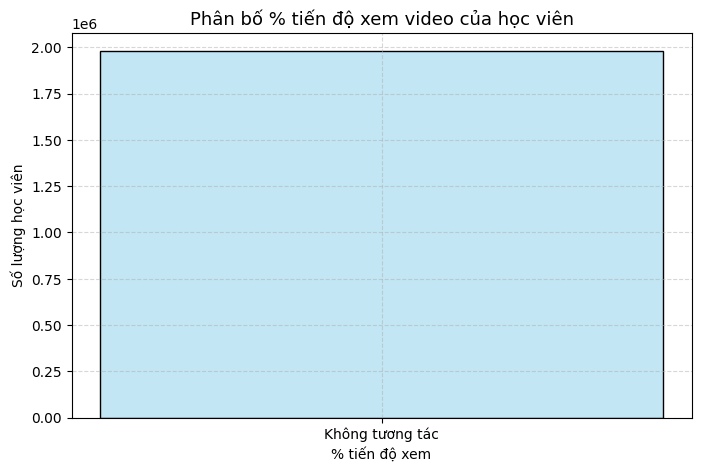

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_plot["progress_percent"], bins=20, kde=True, color="skyblue")
plt.title("Phân bố % tiến độ xem video của học viên", fontsize=13)
plt.xlabel("% tiến độ xem")
plt.ylabel("Số lượng học viên")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [28]:
plt.figure(figsize=(10,5))
video_progress = df_plot.groupby("video_id")["progress_percent"].mean().sort_values(ascending=False).head(20)
sns.barplot(x=video_progress.values, y=video_progress.index, palette="crest")
plt.title("Top 20 video được xem nhiều nhất (theo % hoàn thành trung bình)", fontsize=13)
plt.xlabel("Tiến độ xem trung bình (%)")
plt.ylabel("Mã video")
plt.show()


TypeError: agg function failed [how->mean,dtype->object]

<Figure size 1000x500 with 0 Axes>